# **Deteksi Hate Speech**

**Tigas Adrian Wahyuindrajati**

**DS0127**

**An assignment of Telkom Digital Incubator 2020**
## **Outline**

1. Exploratory Data Analysis
2. Preprocessing
  * Menyeimbangkan label
  * Data Cleaning, Stemming & Stopwords removal
  * Vektorisasi
3. Klasifikasi (Naive Bayes, Gradient Boosting, Neural Network)
  * Pemodelan
  * Evaluasi Model
4. Kesimpulan



In [1]:
! pip install Sastrawi

     |████████████████████████████████| 215kB 12.3MB/s 


In [88]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Exploratory Data Analysis**
1. Dataset terdiri dari 713 tweet
2. Dataset telah diberi label:
  - Non_HS : tweet yang tidak mengandung hate speech
  - HS : tweet yang mengandung hate speech
3. Tidak ada value kosong pada data
4. Jumlah tweet Non_HS dan HS masih tidak seimbang, tweet Non_HS berjumlah 453 tweet (63.53%) sedangkan tweet HS berjumlah 260 tweet (36.47%)
5. 

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/tigasadrian/tugas_DTI/master/data/IDHSD_RIO_unbalanced_713_2017.csv' , sep="," , encoding = "ISO-8859-1")
df

,Label,Tweet
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...
...,...,...
708,HS,Muka Si BABi Ahok Tuh Yg Mirip SERBET Lantai.....
709,HS,"Betul bang hancurkan merka bang, musnahkan chi..."
710,HS,"Sapa Yg bilang Ahok anti korupsi!?, klo grombo..."
711,HS,"Gw juga ngimpi SENTILIN BIJI BABI AHOK, pcetar..."


In [4]:
df.isnull().values.any()

False

In [5]:
df.Label.value_counts()

Non_HS    453
HS        260
Name: Label, dtype: int64

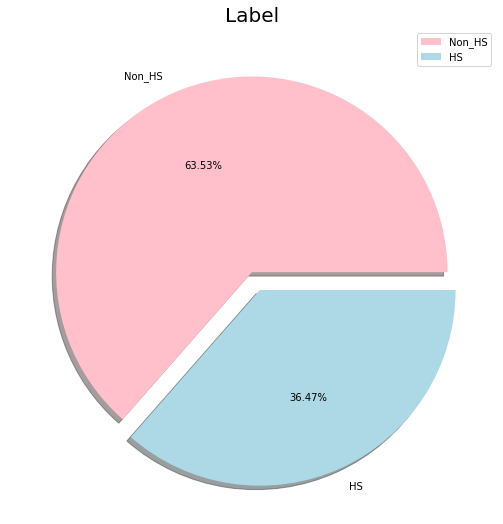

In [75]:
labels = ['Non_HS', 'HS']
size = df['Label'].value_counts()
colors = ['pink', 'lightblue']
explode = [0, 0.1]

plt.rcParams['figure.figsize'] = (9, 9)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Label', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

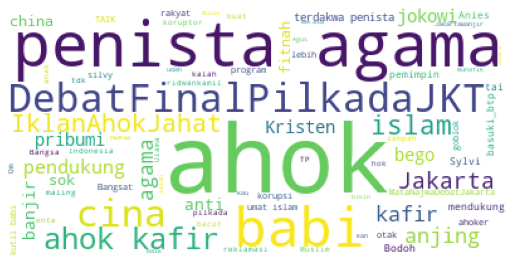

In [129]:
word = df.Tweet[df['Label']=='HS'].astype('string')
stop_factory = StopWordRemoverFactory()
more_stopword = ['lu', 'hahaha', 'debat', 'dgn', 'apa', 'dengan', 'jgn', 'dgn', 'gapunya', 'aja', 'ga', 'gak', 'tau', 'tukang', 'lo', 'kayak', 'kalau', 'memang', 'sangat', 'suka', 'kayak', 'semua', 'sih', 'jangan', 'banget', 'biar', 'mau', 'punya', 'si', 'Orang', 'klo', 'https', 'ngomong', 'gw', 'nya', 'emang', 'bukan', 'hari', 'bisanya', 'jadi', 'tuh', 'RT', 'yg', 'bela', 'kena', 'jelas', 'paling', 'dong', 'kalo', 'sama', 'CO', 'pilih']
stop = stop_factory.get_stop_words()+more_stopword
wordcloud = WordCloud(width=400, height=200, max_font_size=75, max_words=75, background_color="white", stopwords=stop, ).generate_from_text(' '.join(word))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## **Preprocessing**
1. Menyeimbangkan label (Jumlah tweet HS = Jumlah tweet Non_HS)
2. Data Cleaning, Stemming & Stopwords removal
3. Vektorisasi

### **Menyeimbangkan label**

In [8]:
df_NonHS = df.loc[df['Label'] == 'Non_HS']
df_NonHS = df_NonHS.head(259)
df_HS = df.loc[df['Label'] == 'HS']
df_HS = df_HS.head(259)

In [13]:
df_new = df_NonHS.append(df_HS, ignore_index=True)
df_new

,Label,Tweet
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...
...,...,...
513,HS,Gimana dgn Sumber waras.. Trans Jakarta ko jok...
514,HS,Muka Si BABi Ahok Tuh Yg Mirip SERBET Lantai.....
515,HS,"Betul bang hancurkan merka bang, musnahkan chi..."
516,HS,"Sapa Yg bilang Ahok anti korupsi!?, klo grombo..."


### **Data Cleaning, Stemming & Stopwords removal**

In [16]:
def preprocessing(a,b):
    data_fix = []
    from nltk.corpus import stopwords
    for i in range(len(b)):
        text = re.sub('[^a-zA-Z]', ' ', a[i])
        # Remove mentions
        text = re.sub(r'@[A-Za-z0-9_]+', '', a[i])
        # Remove hashtags
        text = re.sub(r'#', '', a[i])
        # Remove retweets:
        text = re.sub(r'RT : ', '', a[i])
        # Remove urls
        text = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', a[i])
        #Case Folding
        text = text.lower()
        #Tokinize
        text = text.split()
        #Stopword + Stemming
        stemmer = StemmerFactory().create_stemmer()        
        text = [stemmer.stem(word) for word in text if not word in set(stopwords.words('indonesian'))]
        text = [word for word in text if len (word) > 3]
        text = ' '.join(text)
        data_fix.append(text)
    return data_fix

In [20]:
length = df_new['Label'].tolist()
df_cleaned = preprocessing(df_fix['Tweet'],length)

In [22]:
# menampilkan dataset dengan tweet yang telah di-cleaning
df_new['Cleaned'] = pd.Series(df_cleaned).values
df_new

,Label,Tweet,Cleaned
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,spardaxyz fadli mendagri nonaktif ahok gubernu...
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...,baguscondromowo luka aksi rangka penjara ahok ...
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...,sylvi gurbernur keras perempuan bukti ibu2 fot...
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...",ahmad dhani puas debat pilkada jalan bekas ung...
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,lisdaulay28 waspada palsu kawal pilkada https ...
...,...,...,...
513,HS,Gimana dgn Sumber waras.. Trans Jakarta ko jok...,gimana sumber waras trans jakarta jokowi diem ...
514,HS,Muka Si BABi Ahok Tuh Yg Mirip SERBET Lantai.....,muka babi ahok serbet lantai basuki btp
515,HS,"Betul bang hancurkan merka bang, musnahkan chi...",bang hancur merka bang musnah china babi bumi ...
516,HS,"Sapa Yg bilang Ahok anti korupsi!?, klo grombo...",sapa bilang ahok anti korupsi grombolannya ngo...


### **Vektorisasi**

In [34]:
tfidf_V = TfidfVectorizer()
X = df_new['Cleaned']
X_vector = tfidf_V.fit_transform(X)
X_vector.shape

(518, 1922)

In [35]:
le = LabelEncoder()
y = le.fit_transform(df_new['Label'])

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_vector, y, test_size=0.3, random_state=0)

## **Klasifikasi**
menggunakan 3 jenis model:
  1. Naive Bayes
  2. Gradient Boosting
  3. Neural Network (Multilayer Perceptron)

### **Naive Bayes**

#### **Pemodelan**

In [60]:
# pemodelan
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

# data testing
y_pred_mnb = mnb.predict(X_test)

#### **Evaluasi Model**

In [61]:
# confusion matrix
cm_mnb = metrics.confusion_matrix(y_test, y_pred_mnb)
cm_mnb

array([[59, 15],
       [15, 67]])

In [69]:
# akurasi model
acc_mnb = metrics.accuracy_score(y_test, y_pred_mnb)
print('Accuracy:', acc_mnb)

Accuracy: 0.8076923076923077


### **Gradient Boosting**

#### **Pemodelan**

In [63]:
# modeling
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

# predict to test data
y_pred_gbc = gbc.predict(X_test)

#### **Evaluasi Model**

In [64]:
cm_gbc = metrics.confusion_matrix(y_test, y_pred_gbc)
cm_gbc

array([[49, 25],
       [ 8, 74]])

In [65]:
acc_gbc = metrics.accuracy_score(y_test, y_pred_gbc)
print('Accuracy:', acc_gbc)

Accuracy: 0.7884615384615384


### **Neural Network**

#### **Pemodelan**

In [66]:
# modeling
mlp = MLPClassifier()
mlp.fit(X_train, y_train)

# predict to test data
y_pred_mlp = mlp.predict(X_test)

#### **Evaluasi Model**

In [67]:
cm_mlp = metrics.confusion_matrix(y_test, y_pred_mlp)
cm_mlp

array([[53, 21],
       [14, 68]])

In [68]:
acc_mlp = metrics.accuracy_score(y_test, y_pred_mlp)
print('Accuracy:', acc_mlp)

Accuracy: 0.7756410256410257


## **Kesimpulan**
Model dengan akurasi tertinggi adalah Naive Bayes dengan akurasi 81%

In [71]:
print('Naive Bayes Accuracy:', acc_mnb)
print('Gradient Boosting Accuracy:', acc_gbc)
print('Neural Network Accuracy:', acc_mlp)

Naive Bayes Accuracy: 0.8076923076923077
Gradient Boosting Accuracy: 0.7884615384615384
Neural Network Accuracy: 0.7756410256410257


# **Referensi**
1. https://github.com/ialfina/id-hatespeech-detection
2. https://github.com/tigasadrian/tugas_DTI/blob/master/clustering.ipynb
3. https://github.com/tigasadrian/tugas_DTI/blob/master/classification.ipynb